In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))
# import seaborn as sns
# sns.set_theme(style="whitegrid")

In [2]:
import os
import sys
sys.path.append('./')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
sys.path.append('../utils')

In [3]:
import UnicycleModel
import UnicycleCost
import UnicycleConstraints
from scipy.integrate import solve_ivp
from PTR import PTR
from LMI import Q_update
from Scaling import TrajectoryScaling
from matplotlib.patches import Ellipse
from utils_plot import plot_traj,plot_traj_set,plot_state_input
from Scaling import TrajectoryScaling
from utils_alg import get_neighbor_vec
import cvxpy as cvx
from utils_alg import get_sample_eta_w
from MSampling import Mstep

In [4]:
ix = 3
iu = 2
iw = 2
iq = 2
ip = 2
N = 30
tf = 3
delT = tf/N
max_iter_SCP = 50

In [5]:
# time-invariant matrices
C = np.array([[0,0,1],[0,0,0]])
D = np.array([[0,0],[1,0]])
E = np.array([[1,0],[0,1],[0,0]])
# F = np.array([[0.1,0],[0,0.1],[0,0]])
G = np.zeros((iq,iw))

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

In [7]:
# plt.figure(figsize=(5,8))
# ax=plt.gca()
# for ce,H in zip(c_list,H_list) :
#     rx = 1/H[0,0]
#     ry = 1/H[1,1]
#     circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
#     ax.add_patch(circle1)
# plt.axis([-0.5, 5.5, -0.5, 5.5])
# plt.gca().set_aspect('equal', adjustable='box')
# plt.grid(True)

## initial and final conditions 

In [8]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

xi_margin = np.array([0.1,0.1,np.deg2rad(5)])*2
Qf = np.diag([0.5**2,0.5**2,np.deg2rad(20)**2])*1.5
vec_neighbor = []
xi_neighbor = np.array(get_neighbor_vec(-1,0,ix,None,vec_neighbor)) * np.array(xi_margin) + xi

myModel = UnicycleModel.unicycle('Hello',ix,iu,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
# u0 = np.random.rand(N,iu)
u0 = np.zeros((N+1,iu))



# Initial setting

## initial trajectory x,u

In [9]:
i1 = PTR('unicycle',N,tf,max_iter_SCP,myModel,myCost,myConst,type_discretization="zoh",
          w_c=1,w_vc=1e3,w_tr=1e-1,tol_vc=1e-6,tol_tr=1e-5,verbosity=False)
x,u,xbar,ubar,total_num_iter,flag_boundary,l,l_vc,l_tr = i1.run(x0,u0,xi,xf)
# plot_traj(xbar,ubar,c_list,H_list,xf)
# plot_state_input(xbar,ubar,xi,xf,N,delT)

iteration   total_cost        cost        ||vc||     ||tr||       reduction   w_tr        bounary
9           207.681           207.681     4.01e-10    1.7e-06     -2.71e-05   0.100       1(9.96e-08)
SUCCEESS: virtual control and trust region < tol


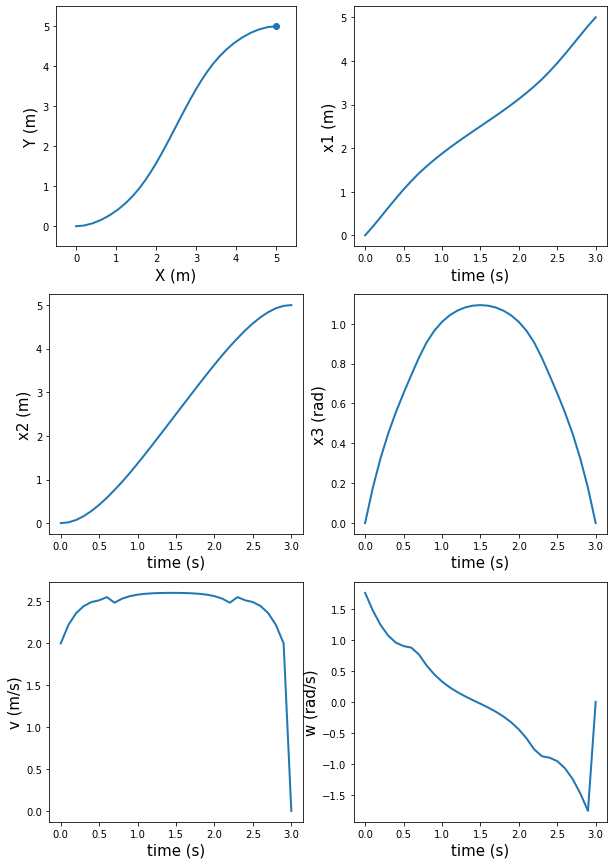

In [10]:
plt.figure(0,figsize=(10,15))
tbar = np.array(range(N+1))*delT
plot_state_input(tbar,xbar,ubar,xi,xf,N,delT,alpha=1.0,plt=plt)

## Initial trajectory Q, K

In [11]:
# get LQR K
# A,B,s,z,vc = i1.get_model()
# C = s+z
A,B = myModel.diff_numeric_central(xbar,ubar)
F = myModel.diff_F1(xbar,ubar,np.zeros((N,iw)))
from utils_alg import get_K
S = np.eye(ix)
R = 2*np.eye(iu)
# R[1,1] *= 0.1
S_final = 2*np.eye(ix)
Kbar = get_K(A[:N],B[:N],S,R,N,ix,iu)
Qbar = np.tile(np.diag([0.3**2,0.3**2,np.deg2rad(10)**2]),(N+1,1,1))

In [12]:
Ybar = Kbar@Qbar[:N]
print_np(Ybar)

Type is <class 'numpy.ndarray'>
Shape is (30, 2, 3)


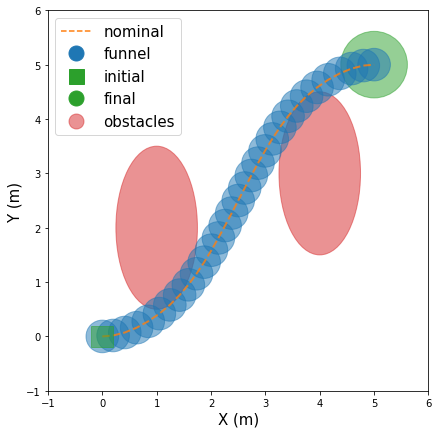

In [13]:
plt.figure(0,figsize=(7,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)


## step 1 : Nominal trajectory update

In [ ]:
x0 = xbar
u0 = ubar

# SCP
i1 = PTR('unicycle',N,tf,1,myModel,myCost,myConst,type_discretization="zoh",
          w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=False)
_,_,x,u,total_num_iter,flag_boundary,l,l_vc,l_tr = i1.run(x0,u0,xi,xf,Qbar,Kbar)#,xi_neighbor,xf_margin)


In [ ]:
plt.figure(0,figsize=(7,7))
plot_traj_set(x,u,c_list,H_list,Qbar,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)

In [ ]:
plt.figure(0,figsize=(10,15))
tbar = np.array(range(N+1))*delT
plot_state_input(tbar,x,u,xi,xf,N,delT,alpha=1.0,plt=plt)

## step 2 : Estimating gamma

In [ ]:
# step 2
A,B = myModel.diff_numeric_central(xbar,ubar)
myM = Mstep(ix,iu,iq,ip,iw,N)
myM.initialize(xbar,ubar,Qbar,Kbar,A,B,C,D,E,F,G,myModel)

In [ ]:
import time

In [ ]:
start = time.time()
gamma = myM.update_lipschitz()
print(time.time()-start)
print("mean of gamma",np.mean(gamma))
print("max of gamma",np.max(gamma))

In [ ]:
start = time.time()
gamma = myM.update_lipschitz_parallel()
print(time.time()-start)
print("mean of gamma",np.mean(gamma))
print("max of gamma",np.max(gamma))

In [ ]:
start = time.time()
gamma = myM.update_lipschitz_parallel2()
print(time.time()-start)
print("mean of gamma",np.mean(gamma))
print("max of gamma",np.max(gamma))

## step 3 : Funnel update

In [ ]:
# step 3
myQ = Q_update(ix,iu,iq,ip,iw,N,delT,myCost.S,myCost.R)
myQ.initialize(x,u,A,B,C,D,E,F,G)

Q,K,Y,status = myQ.solve_type_1(gamma,xi_neighbor,Qf,Qbar,Ybar)
print("LMI status:" + status)

In [ ]:
# plot the trajectory
plt.figure(0,figsize=(7,7))
plot_traj_set(x,u,c_list,H_list,Q,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)
plt.show()

In [ ]:
# plot the trajectory
plt.figure(0,figsize=(7,7))
plot_traj_set(x,u,c_list,H_list,Q,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)
plt.show()